In [2]:
import os
import numpy as np
from custom_datagen import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [3]:
train_img_dir = "BraTS2020_TrainingData\\input_data_3channels\\images\\"
train_mask_dir = "BraTS2020_TrainingData\\input_data_3channels\\masks\\"

In [4]:
#Extracting the file names
img_list = os.listdir(train_img_dir)
mask_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

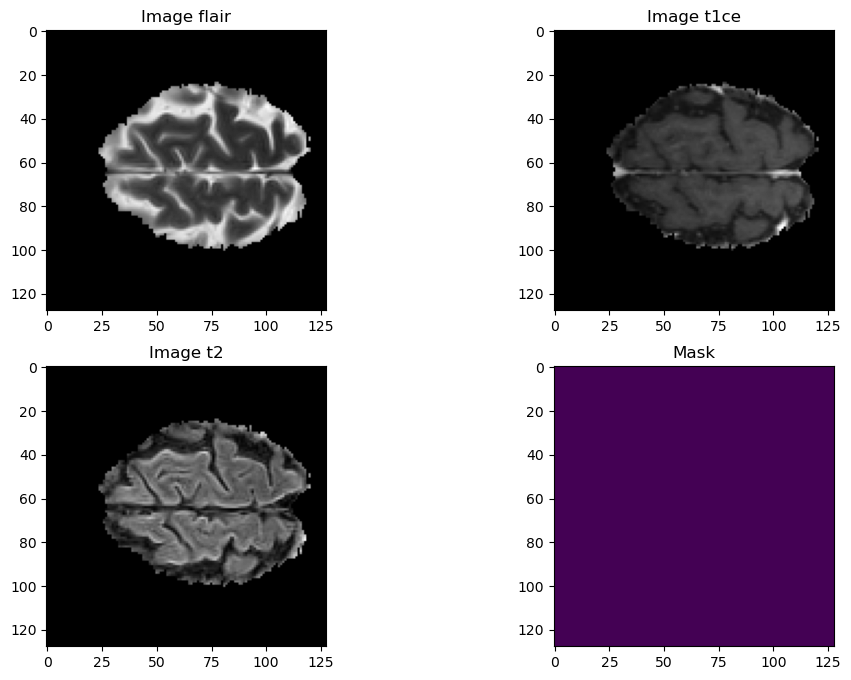

In [5]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [6]:
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

# import pandas as pd
# columns = ['0','1', '2', '3']
# df = pd.DataFrame(columns=columns)
# train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
# for img in range(len(train_mask_list)):
#     print(img)
#     temp_image=np.load(train_mask_list[img])
#     temp_image = np.argmax(temp_image, axis=3)
#     val, counts = np.unique(temp_image, return_counts=True)
#     zipped = zip(columns, counts)
#     conts_dict = dict(zipped)
    
#     df = df.append(conts_dict, ignore_index=True)

# label_0 = df['0'].sum()
# label_1 = df['1'].sum()
# label_2 = df['1'].sum()
# label_3 = df['3'].sum()
# total_labels = label_0 + label_1 + label_2 + label_3
# n_classes = 4
# #Class weights claculation: n_samples / (n_classes * n_samples_for_class)
# wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
# wt1 = round((total_labels/(n_classes*label_1)), 2)
# wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

# #Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

#### Training the Model

In [7]:
train_img_dir = "BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "BraTS2020_TrainingData\\input_data_128\\train\\masks\\"

val_img_dir = "BraTS2020_TrainingData\\input_data_128\\val\\images\\"
val_mask_dir = "BraTS2020_TrainingData\\input_data_128\\val\\masks\\"

In [8]:
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [9]:
batch_size = 2

In [10]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

In [11]:
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [12]:
img,mask = train_img_datagen.__next__()

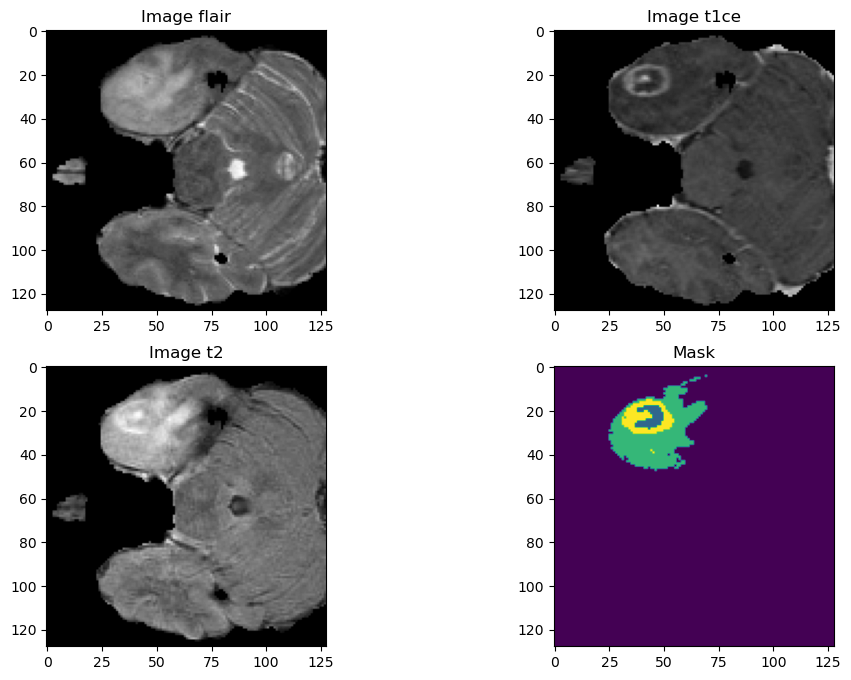

In [13]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=mask[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### Defining the metrices and optimizers to be used for training

In [14]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
#defining equal weights for all can be changed using above commented code for weight generation

In [15]:
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [16]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [17]:
metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5)]

In [18]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

In [21]:
pyth pip install nvidia-cudnn-cu11==8.6.0.163 tensorflow==2.12.*

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement nvidia-cudnn-cu11==8.6.0.163 (from versions: 0.0.1.dev5)
ERROR: No matching distribution found for nvidia-cudnn-cu11==8.6.0.163


In [22]:
tf.config.list_physical_devices('GPU')

[]

#### Fitting The Model ####


In [18]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [19]:
from Model import simple_unet_model

In [20]:
model = simple_unet_model(img_height = 128,
                         img_width = 128,
                         img_depth = 128,
                         img_channels = 3,
                         num_classes = 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

In [21]:
model.compile(optimizer = optim, loss = total_loss, metrics = metrics)

In [22]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

In [30]:
history = model.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                   epochs = 1,
                   verbose = 1,
                   validation_data = val_img_datagen,
                   validation_steps = val_steps_per_epoch,
                   )

129/129 [==============================] - 10626s 82s/step - loss: 0.9615 - accuracy: 0.8106 - iou_score: 0.1766 - val_loss: 0.9447 - val_accuracy: 0.9502 - val_iou_score: 0.2007


In [32]:
model.save('brats_3d.hdf5')

<function matplotlib.pyplot.show(close=None, block=None)>

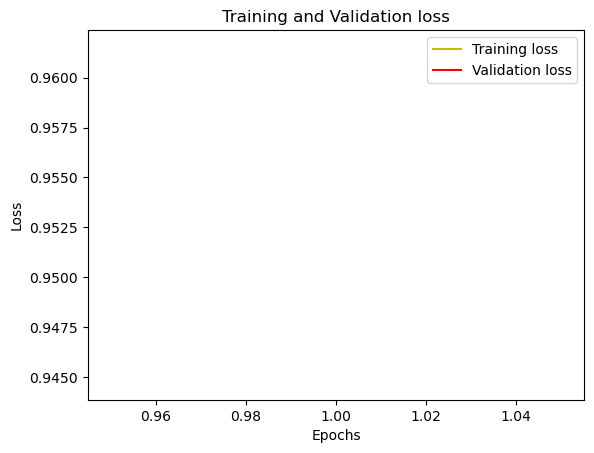

In [33]:
#Use when u have a huge number of epochs to visualise the loss while each epoch cycle

# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1,len(loss)+1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and Validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show

Loading the Model for further training: 

In [11]:
from keras.models import load_model

In [37]:
# my_model = load_model('brats_3d.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})
# my_model

In [ ]:
#Now all set to continue the training process. 
# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=1,     //increase the epochs as desired
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )

Loading the Model for Prediction

In [12]:
my_model = load_model('brats_3d.hdf5', 
                      compile=False)

In [14]:
#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=4 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [15]:
#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

In [16]:
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

1/1 [==============================] - 10s 10s/step


In [17]:
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.23891793


In [42]:
#Predict on a few test images, one at a time
#Try images: 
img_num = 0

test_img = np.load(train_img_dir+"\\image_"+str(img_num)+".npy")

test_mask = np.load(train_mask_dir+"masks_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]

1/1 [==============================] - 2s 2s/step


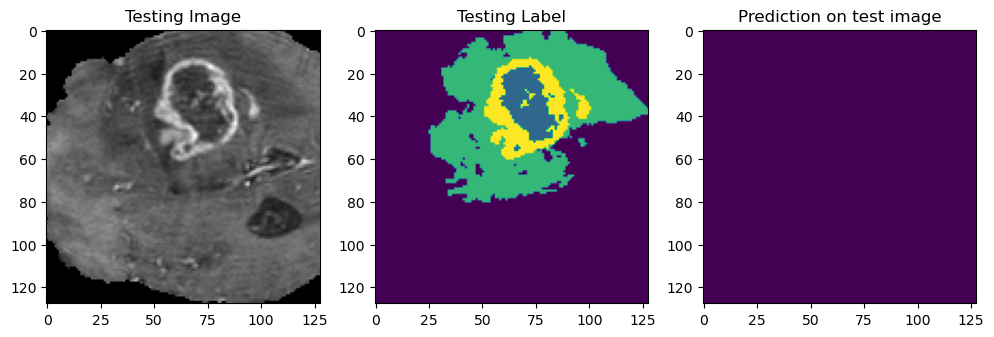

In [46]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()